In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

Dataset URL: https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset
License(s): unknown
  0% 0.00/121M [00:00<?, ?B/s]
100% 121M/121M [00:00<00:00, 1.28GB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/face-expression-recognition-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten

In [ ]:
#Generators in Keras where we work on batches to process images
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/images/train',
    labels='inferred',
    label_mode = 'categorical',
    batch_size=32,
    image_size=(48,48),
    color_mode='grayscale' # Specify grayscale
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/images/validation',
    labels='inferred',
    label_mode = 'categorical',
    batch_size=32,
    image_size=(48,48),
    color_mode='grayscale' # Specify grayscale
)

Found 28821 files belonging to 7 classes.
Found 7066 files belonging to 7 classes.


In [ ]:
# Normalize so that we don't have 0-255 but 0-1
def process(image, label):
  image = tf.cast(image/255. ,tf.float32)
  return image, label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [ ]:
#Import batchnormalization and dropout from keras
from keras.layers import BatchNormalization, Dropout


In [ ]:
# Create CNN model

model = Sequential()

#Convolution Layer-1
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(48,48,1))) # Change input shape to 1 for grayscale
#Normalization Layer
model.add(keras.layers.BatchNormalization())
#Pooling layer
model.add(MaxPool2D(pool_size=(2,2), strides=2, padding='valid'))

#Convolution Layer-2
model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
#Normalization Layer
model.add(keras.layers.BatchNormalization())
#Pooling layer
model.add(MaxPool2D(pool_size=(2,2), strides=2, padding='valid'))

#Convolution Layer-3
model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
#Normalization Layer
model.add(keras.layers.BatchNormalization())
#Pooling layer
model.add(MaxPool2D(pool_size=(2,2), strides=2, padding='valid'))



#Flattening
model.add(Flatten())

#Full-Connected ANN
model.add(Dense(units=128, activation='relu'))

#Dropout layers
model.add(keras.layers.Dropout(0.5))
model.add(Dense(units=7, activation='softmax'))

model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)              │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,423 (2.61 MB)

 Trainable params: 683,975 (2.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#Fit model
history = model.fit(train_ds, epochs=30, validation_data=validation_ds)

Epoch 1/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6341 - loss: 0.9517 - val_accuracy: 0.5133 - val_loss: 1.4306
Epoch 2/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.6429 - loss: 0.9401 - val_accuracy: 0.5372 - val_loss: 1.5010
Epoch 3/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6593 - loss: 0.9023 - val_accuracy: 0.5277 - val_loss: 1.5966
Epoch 4/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6574 - loss: 0.9088 - val_accuracy: 0.5137 - val_loss: 1.4815
Epoch 5/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.6709 - loss: 0.8570 - val_accuracy: 0.5130 - val_loss: 1.5153
Epoch 6/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6762 - loss: 0.8580 - val_accuracy: 0.5184 - val_loss: 1.5332
Epoch 7/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.6877 - loss: 0.8212 - val_accuracy: 0.5461 - val_loss: 1.5218
Epoch 8/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6907 - loss: 0.8160 - val_accuracy: 0

KeyboardInterrupt: 

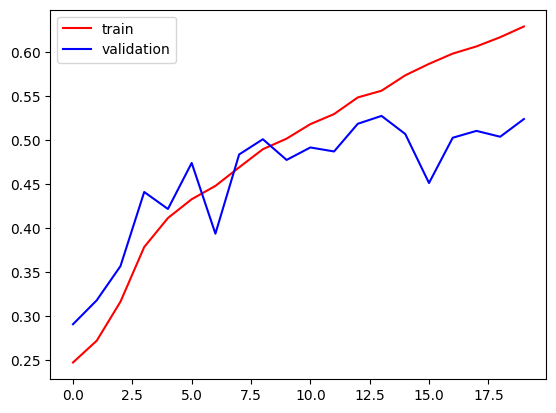

In [ ]:
#Graph between Validation Accuracy and training accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], color='red', label='train')
plt.plot(history.history['val_accuracy'], color='blue', label='validation')
plt.legend()
plt.show()

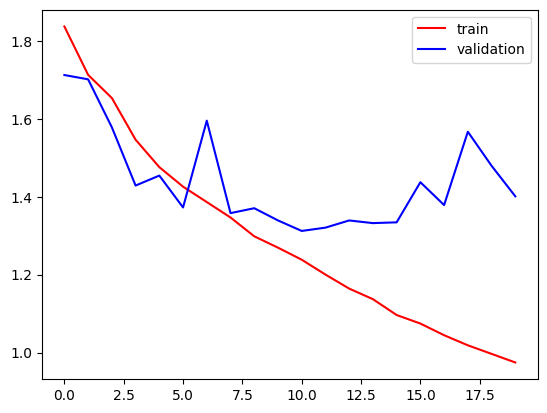

In [ ]:
#graph between validation loss and train loss
plt.plot(history.history['loss'], color='red', label='train')
plt.plot(history.history['val_loss'], color='blue', label='validation')
plt.legend()
plt.show()

In [ ]:
import cv2

In [ ]:
test_img = cv2.imread("/content/sadman.jpg", cv2.IMREAD_GRAYSCALE)

In [ ]:
test_img.shape

(489, 626)

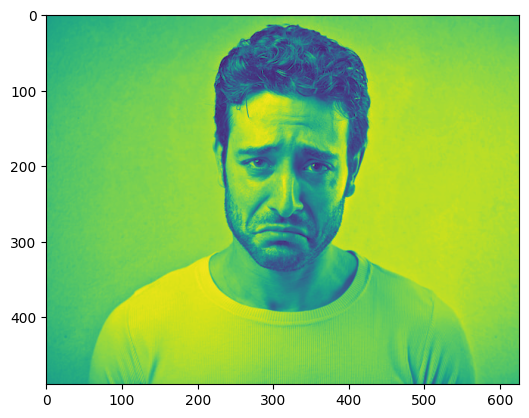

In [ ]:
plt.imshow(test_img)

In [ ]:
test_img = cv2.resize(test_img, (48,48))

array([[136, 142, 142, ..., 177, 176, 171],
       [141, 145, 145, ..., 180, 179, 178],
       [143, 145, 155, ..., 183, 180, 179],
       ...,
       [147, 146, 148, ..., 179, 176, 175],
       [141, 142, 148, ..., 176, 173, 169],
       [138, 142, 145, ..., 170, 168, 163]], dtype=uint8)
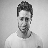

In [ ]:
test_img

In [ ]:
test_input = test_img.reshape((1,48,48,1))

In [ ]:
model.predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step


array([[0.0000000e+00, 0.0000000e+00, 2.6864947e-19, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 1.0000000e+00]], dtype=float32)

In [ ]:
test_img = cv2.imread("/content/happy.jpg", cv2.IMREAD_GRAYSCALE)

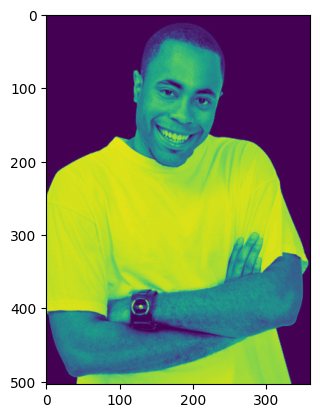

In [ ]:
plt.imshow(test_img)

In [ ]:
test_img = cv2.resize(test_img, (48,48))

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
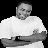

In [ ]:
test_img

In [ ]:
test_input = test_img.reshape((1,48,48,1))

In [ ]:
#Give me label of the prediction as well
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
#Let's predict with labelname
labels[model.predict(test_input)[0].argmax()]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


'Happy'

In [ ]:
def label(num):
  labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
  print(labels[num])


In [ ]:
test_img = cv2.imread("/content/feartest.jpg", cv2.IMREAD_GRAYSCALE)
test_img = cv2.resize(test_img, (48,48))
test_input = test_img.reshape((1,48,48,1))
label(model.predict(test_input)[0].argmax())

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
Angry


In [ ]:
#Save this model in pickle file
import pickle
pickle.dump(model, open('model.pkl', 'wb'))

In [ ]:
#import pickle file and let's do prediction form it
model = pickle.load(open('model.pkl', 'rb'))
#Add preprocessing layer so that our image is preprocess to be accepted by model
#Predict image at /content/dogs_vs_cats/train/dogs/dog.1.jpg
test_img = cv2.imread("/content/happy.jpg", cv2.IMREAD_GRAYSCALE)
test_img = cv2.resize(test_img, (48,48))
test_input = test_img.reshape((1,48,48,1))
label(model.predict(test_input)[0].argmax())

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
Happy
